In [1]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import preprocessing
from scipy.io import loadmat
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import keras
import tensorflow as tf
from keras import Model, activations, layers
from keras.layers import Dense, Reshape, Concatenate, GlobalAveragePooling1D, Embedding, LayerNormalization
from keras.layers import MultiHeadAttention, Dropout, Add, Permute, BatchNormalization, Conv1D, Flatten
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping
import random

%env CUDA_VISIBLE_DEVICES=1

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

IMG_SIZE = 224
BATCH_SIZE = 32

env: CUDA_VISIBLE_DEVICES=-1


In [2]:
SEED_IV_LOCATION_LIST = [
    ['-', '-', '-', 'FP1', 'FPZ', 'FP2', '-', '-', '-'],
    ['-', '-', '-', 'AF3', '-', 'AF4', '-', '-', '-'],
    ['F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8'],
    ['FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8'],
    ['T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8'],
    ['TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8'],
    ['P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8'],
    ['-', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', '-'],
    ['-', '-', 'CB1', 'O1', 'OZ', 'O2', 'CB2', '-', '-']
]


channels_division = {
#                      1: [['-','-','-'],['-','-','-'],['F7', 'F5', 'F3']], 
#                      2: [['FP1', 'FPZ', 'FP2'],['AF3', '-', 'AF4'],['F1', 'FZ', 'F2']],
#                      3: [['-','-','-'],['-','-','-'],['F4', 'F6', 'F8'],
                     4: [['FT7', 'FC5', 'FC3'],['T7', 'C5', 'C3'],['TP7', 'CP5', 'CP3']],
                     5: [['FC1', 'FCZ', 'FC2'],['C1', 'CZ', 'C2'],['CP1', 'CPZ', 'CP2']],
                     6: [['FC4', 'FC6', 'FT8'],['C4', 'C6', 'T8'],['CP4', 'CP6', 'TP8']],
#                      7: [['P7', 'P5', 'P3'],['-', 'PO7', 'PO5'],['-', '-', 'CB1']],
                     8: [['P1', 'PZ', 'P2'],['PO3', 'POZ', 'PO4'],['O1', 'OZ', 'O2']],
#                      9: [['P4', 'P6', 'P8'],['PO6', 'PO8', '-'],['CB2', '-', '-']]
                    }

labels_exp_1=['1','2','3','0','2','0','0','1','0','1','2','1','1','1','2','3','2','2','3','3','0','3','0','3']
labels_exp_2=['2','1','3','0','0','2','0','2','3','3','2','3','2','0','1','1','2','1','0','3','0','1','3','1']
labels_exp_3=['1','2','2','1','3','3','3','1','1','2','1','0','2','3','3','0','2','3','0','0','2','0','1','0']

test_indexes_1 = sorted([23,22,21,20,17,16,13,12])
test_indexes_2 = sorted([23,22,21,20,19,18,16,12])
test_indexes_3 = sorted([23,22,21,20,17,16,13,10])

train_indexes_1 = [i for i in range(24) if i not in test_indexes_1]
train_indexes_2 = [i for i in range(24) if i not in test_indexes_2]
train_indexes_3 = [i for i in range(24) if i not in test_indexes_3]

channel_order = ['FP1','FPZ','FP2','AF3','AF4','F7','F5','F3','F1','FZ','F2','F4','F6','F8','FT7','FC5','FC3','FC1',
                 'FCZ','FC2','FC4','FC6','FT8','T7','C5','C3','C1','CZ','C2','C4','C6','T8','TP7','CP5','CP3','CP1',
                 'CPZ','CP2','CP4','CP6','TP8','P7','P5','P3','P1','PZ','P2','P4','P6','P8','PO7','PO5','PO3','POZ',
                 'PO4','PO6','PO8','CB1','O1','OZ','O2','CB2']

In [10]:
base_dir = ''
dir_paths =['eeg_feature_smooth/1/','eeg_feature_smooth/2/','eeg_feature_smooth/3/']

channel_group=1
freq_bands=[0,1,2,3,4]

train_indexes_1 = [i for i in range(24)]
train_indexes_2 = [i for i in range(24)]
train_indexes_3 = [i for i in range(24)]

def get_data(channel_group=10, freq_bands=[0,1,2,3,4], repeat = 1):
    file_label=[]

    ch_list = channels_division[channel_group]
    channels = [[channel_order.index(ch_) for ch_ in ch] for ch in ch_list]
    channels = [j for sub in channels for j in sub]

    train_x = []
    test_x = []
    train_y = []
    test_y = []

    for directory in sorted(dir_paths):
        trial_num = int(directory.split('/')[-2])
        files = [f for f in os.listdir(os.path.join(base_dir, directory)) if os.path.isfile(os.path.join(base_dir, directory, f))]
        f=1

        for file in sorted(files):
            subject_num = int(file.split('_')[0])
            df = loadmat(directory+file)
            columns=list(df.keys())


            i=3
            subset=[]

            while i<99:
                subset.append(columns[i])
                i=i+4

            if directory == 'eeg_feature_smooth/1/':
                indexes = sorted(train_indexes_1)
            if directory == 'eeg_feature_smooth/2/':
                indexes = sorted(train_indexes_2)
            if directory == 'eeg_feature_smooth/3/':
                indexes = sorted(train_indexes_3)
            
            for r in range(1):
                for i in indexes:
                    col = subset[i]
                    trial = []
                    for freq in freq_bands:
                        frequency = []
                        for chn in channels:
                            a1= df[col][chn,:,freq]
                            padded_array1 = np.zeros((64, ))
                            shape1 = np.shape(a1)
                            padded_array1[:shape1[0],] = a1
                            frequency.append(padded_array1)

                        if r == 0:
                            trial.append(frequency)
                        else:
                            data = list(range(0, len(frequency)))
                            random.shuffle(data)
                            k1, k2 = data[:2]
                            frequency[k1], frequency[k2] = frequency[k2], frequency[k1]
                            trial.append(frequency)
#                         trial.append(frequency)

                    train_x.append(trial)

                if directory == 'eeg_feature_smooth/1/':
                    labels = [labels_exp_1[j] for j in indexes]
                    train_y.extend(labels)
                if directory == 'eeg_feature_smooth/2/':
                    labels = [labels_exp_2[j] for j in indexes]
                    train_y.extend(labels)
                if directory == 'eeg_feature_smooth/3/':
                    labels = [labels_exp_3[j] for j in indexes]
                    train_y.extend(labels)
    
            if directory == 'eeg_feature_smooth/1/':
                indexes = sorted(test_indexes_1)
            if directory == 'eeg_feature_smooth/2/':
                indexes = sorted(test_indexes_2)
            if directory == 'eeg_feature_smooth/3/':
                indexes = sorted(test_indexes_3)

            for i in indexes:
                col = subset[i]
                trial = []
                for freq in freq_bands:
                    frequency = []
                    for chn in channels:
                        a1= df[col][chn,:,freq]
                        padded_array1 = np.zeros((64, ))
                        shape1 = np.shape(a1)
                        padded_array1[:shape1[0],] = a1
                        frequency.append(padded_array1)

                    trial.append(frequency)

                test_x.append(trial)

            if directory == 'eeg_feature_smooth/1/':
                labels = [labels_exp_1[j] for j in indexes]
                test_y.extend(labels)
            if directory == 'eeg_feature_smooth/2/':
                labels = [labels_exp_2[j] for j in indexes]
                test_y.extend(labels)
            if directory == 'eeg_feature_smooth/3/':
                labels = [labels_exp_3[j] for j in indexes]
                test_y.extend(labels)
    
    train_x = np.array(train_x).transpose((0,1,2,3))  # (0,3,1,2))
    train_x = np.array(train_x).transpose((0,1,2,3))  # (0,3,1,2))
    
    return np.array(train_x), np.array(train_y) #, np.array(test_x), np.array(test_y)

central_x, central_Y = get_data(channel_group=4, freq_bands=freq_bands)

In [11]:
central_x.shape

(1080, 5, 9, 64)

In [12]:
from sklearn.model_selection import KFold

freq_bands = [0,1,2,3]

central_x, central_y = get_data(channel_group=4, freq_bands=freq_bands)

rtemporal_x, rtemporal_y = get_data(channel_group=4, freq_bands=freq_bands)

parietal_x, parietal_y = get_data(channel_group=4, freq_bands=freq_bands)

occipital_x, occipital_y = get_data(channel_group=4, freq_bands=freq_bands)

In [6]:
# Electrode Patch encoder
class LinearEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(LinearEmbedding, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.expand = expand
        # Create class token
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        # Dense layer for linear transformation of electrode patches (Map to constant size De)
        self.projection = Dense(projection_dim)
        # Embedding layer for positional embeddings
        self.position_embedding = Embedding(input_dim=num_patches+1, output_dim=projection_dim)
        self.dropout = Dropout(0.3)  # 0.1

    def call(self, patch, *kwargs):
        # For brain-region-level spatial learning
        batch = tf.shape(patch)[0]
        class_token = tf.tile(self.class_token, multiples=[batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        patches_embed = self.projection(patch)
        patches_embed = self.dropout(patches_embed)
        patches_embed = tf.concat([class_token, patches_embed], 1)
        # calculate position embeddings
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        positions_embed = self.position_embedding(positions)
        # Add positions to patches
        encoded = patches_embed + positions_embed
        return encoded

# MLP
class MLP(layers.Layer):
    def __init__(self, hidden_states, output_states, dropout=dropout_rate):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_states, activation=tf.nn.gelu)  #gelu
        self.dense2 = Dense(output_states, activation=tf.nn.gelu)  #gelu
        self.dropout = Dropout(dropout)

    def call(self, x, *kwargs):
        hidden = self.dense1(x)
        dr_hidden = self.dropout(hidden)
        output = self.dense2(dr_hidden)
        dr_output = self.dropout(output)
        return dr_output

# Transformer Encoder Block
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, model_dim, num_heads=k, msa_dimensions=Dh):
        super(TransformerEncoderBlock, self).__init__()
        self.model_dim = model_dim
        self.layernormalization1 = LayerNormalization(epsilon=1e-6)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=msa_dimensions, dropout=dropout_rate)
        self.layernormalization2 = LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(hidden_states=model_dim * 4, output_states=model_dim)

    def call(self, x, *kwargs):
        # layer normalization 1.
        x1 = self.layernormalization1(x)  # encoded_patches
        # create a multi-head attention layer.
        attention_output = self.attention(x1, x1)
        # skip connection 1.
        x2 = Add()([attention_output, x])  # encoded_patches
        # layer normalization 2.
        x3 = self.layernormalization2(x2)
        # mLP.
        x3 = self.mlp(x3)
        # skip connection 2.
        y = Add()([x3, x2])
        return y

#  Transformer Encoder Block x L Repeat
class TransformerEncoder(layers.Layer):
    def __init__(self, model_dim, num_blocks):
        super(TransformerEncoder, self).__init__()
        self.blocks = [TransformerEncoderBlock(model_dim, num_blocks) for _ in range(num_blocks)]

    def call(self, x, *kwargs):
        # create a [batch_size, projection_dim] tensor.
        for block in self.blocks:
            x = block(x)
        return x

In [5]:
Dr = 64  # embedding dimension (brain - region level)
Lr = 8  # no of encoder (brain - region level)
dropout_rate = 0.4  # Dropout rate
k = 16  # num of heads in MSA 8

In [13]:
def HierarchicalTransformer():
    N = 9
    timesteps = 64
    d=4
    
    conv = layers.Conv2D(16, (2,2), activation = 'relu')
    batch_norm = BatchNormalization()
    dropout = Dropout(0.5)

    # 4. Brain region (Central)
    input_1 = keras.Input(shape=(d, 9, timesteps))
    electrode_patch_c = conv(input_1)
    electrode_patch_c = batch_norm(electrode_patch_c)
    electrode_patch_c = Flatten()(electrode_patch_c)
    output_c = (electrode_patch_c)

    # 5. Brain region (Right Temporal)
    input_2 = keras.Input(shape=(d, 9, timesteps))
    electrode_patch_rt = conv(input_2)
    electrode_patch_rt = batch_norm(electrode_patch_rt)
    electrode_patch_rt = Flatten()(electrode_patch_rt)
    output_rt = dropout(electrode_patch_rt)

    # 6. Brain region (Left Parietal)
    input_3 = keras.Input(shape=(d, 9, timesteps))
    electrode_patch_lp = conv(input_3)
    electrode_patch_lp = batch_norm(electrode_patch_lp)
    electrode_patch_lp = Flatten()(electrode_patch_lp)
    output_lp = dropout(electrode_patch_lp)

    # 8. Brain region (Right Parietal)
    input_4 = keras.Input(shape=(d, 9, timesteps))
    electrode_patch_rp = conv(input_4)
    electrode_patch_rp = batch_norm(electrode_patch_rp)
    electrode_patch_rp = Flatten()(electrode_patch_rp)
    output_rp = dropout(electrode_patch_rp)

    xl = Concatenate(axis=1)([output_c, output_rt, output_lp, output_rp]) # 2
    
    print(xl.shape)
    
    outputs_br = LinearEmbedding(8, Dr)(xl)   # (None, 10, Dr)
    outputs_br = TransformerEncoder(Dr, Lr)(outputs_br)
    class_token_output = outputs_br[:, 0, :]  # (None, Dr)
    brain_regions_embeddings = Flatten()(class_token_output)
    brain_regions_embeddings = BatchNormalization()(brain_regions_embeddings)
    brain_regions_embeddings = Dropout(dropout_rate)(brain_regions_embeddings)
    brain_regions_embeddings = Dense(128, activation='relu')(brain_regions_embeddings)
    brain_regions_embeddings = BatchNormalization()(brain_regions_embeddings)
    brain_regions_embeddings = Dropout(dropout_rate)(brain_regions_embeddings)
    
    prediction = Dense(4, activation=activations.softmax)(brain_regions_embeddings)
    
    hslt = Model(inputs=[input_1, input_2, input_3, input_4],
                 outputs=prediction)

    return hslt


model = HierarchicalTransformer()

model.summary()

(None, 1536)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 9, 64)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4, 9, 64)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4, 9, 64)]   0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 4, 9, 64)]   0           []                               
                                                                                 

# K-fold cross-validation training

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

epochs = 300
batch_size = 10

average_results_acc = []
conf_mat = []


for train_index, test_index in StratifiedKFold(5, shuffle=True, random_state=42).split(rtemporal_x, rtemporal_y):
    tf.keras.backend.clear_session()
    
    x_train1, x_test1 = central_x[train_index], central_x[test_index]
    y_train1, y_test1 = central_y[train_index], central_y[test_index]
    
    x_train2, x_test2 = rtemporal_x[train_index], rtemporal_x[test_index]
    y_train2, y_test2 = rtemporal_y[train_index], rtemporal_y[test_index]
    
    x_train3, x_test3 = parietal_x[train_index], parietal_x[test_index]
    y_train3, y_test3 = parietal_y[train_index], parietal_y[test_index]
    
    x_train4, x_test4 = occipital_x[train_index], occipital_x[test_index]
    y_train4, y_test4 = occipital_y[train_index], occipital_y[test_index]

    train_labels = to_categorical(y_train1, 4)
    test_labels = to_categorical(y_test1, 4)
    
    num_train_steps = (train_labels.shape[0] // batch_size) * epochs
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.005, 
                                                            decay_steps=num_train_steps)
    
    model = HierarchicalTransformer()
    mc = ModelCheckpoint('best.h5', save_best_only=True, monitor='val_accuracy')
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr_schedule), #learning_rate=1e-3, weight_decay=0.005),  # lr_schedule
        metrics=['accuracy']
    )

    history = model.fit(
        x=[x_train1, x_train2, x_train3, x_train4],
        y=train_labels,
        validation_data=([x_test1, x_test2, x_test3, x_test4], test_labels),
#         class_weight=class_weights,
        epochs=epochs, batch_size=batch_size,
        callbacks=[mc]  #, callbacks=[early_stopping]
    )
    
    model.load_weights('best.h5')
    
    prediction = model.predict([x_test1, x_test2, x_test3, x_test4])

    prediction_bool = np.argmax(prediction, axis=1)
    true_bool = np.argmax(test_labels, axis=1)
    
    cm=metrics.confusion_matrix(true_bool, prediction_bool)
    conf_mat.append(cm)

    # Confusion Matrix
    accuracy = metrics.accuracy_score(true_bool, prediction_bool)
    average_results_acc.append(accuracy)

(None, 1536)
Epoch 1/300
87/87 [==============================] - 2s 11ms/step - loss: 1.6350 - accuracy: 0.3785 - val_loss: 1.3966 - val_accuracy: 0.3704
Epoch 2/300
87/87 [==============================] - 1s 9ms/step - loss: 1.2814 - accuracy: 0.4769 - val_loss: 1.3475 - val_accuracy: 0.4398
Epoch 3/300
87/87 [==============================] - 1s 10ms/step - loss: 1.1792 - accuracy: 0.5093 - val_loss: 1.0144 - val_accuracy: 0.5880
Epoch 4/300
87/87 [==============================] - 1s 9ms/step - loss: 1.0260 - accuracy: 0.5602 - val_loss: 1.2940 - val_accuracy: 0.4213
Epoch 5/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9329 - accuracy: 0.5961 - val_loss: 1.8059 - val_accuracy: 0.4028
Epoch 6/300
87/87 [==============================] - 1s 10ms/step - loss: 0.9812 - accuracy: 0.5856 - val_loss: 0.9865 - val_accuracy: 0.6019
Epoch 7/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9399 - accuracy: 0.6227 - val_loss: 1.0805 - val_accuracy: 0.49

87/87 [==============================] - 1s 9ms/step - loss: 0.6268 - accuracy: 0.6944 - val_loss: 0.5251 - val_accuracy: 0.6944
Epoch 116/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6056 - accuracy: 0.7106 - val_loss: 0.5968 - val_accuracy: 0.6944
Epoch 117/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6063 - accuracy: 0.7106 - val_loss: 0.5279 - val_accuracy: 0.7222
Epoch 118/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6311 - accuracy: 0.7280 - val_loss: 0.5083 - val_accuracy: 0.7361
Epoch 119/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6284 - accuracy: 0.7095 - val_loss: 0.4900 - val_accuracy: 0.7315
Epoch 120/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6174 - accuracy: 0.7095 - val_loss: 0.4979 - val_accuracy: 0.7546
Epoch 121/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6037 - accuracy: 0.7118 - val_loss: 0.5382 - val_accuracy: 0.7176
Epoch 122/300

87/87 [==============================] - 1s 9ms/step - loss: 0.5513 - accuracy: 0.7269 - val_loss: 0.4918 - val_accuracy: 0.7407
Epoch 230/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5914 - accuracy: 0.7199 - val_loss: 0.4901 - val_accuracy: 0.7500
Epoch 231/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5643 - accuracy: 0.7222 - val_loss: 0.4918 - val_accuracy: 0.7407
Epoch 232/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5709 - accuracy: 0.7118 - val_loss: 0.4923 - val_accuracy: 0.7222
Epoch 233/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5626 - accuracy: 0.7199 - val_loss: 0.5537 - val_accuracy: 0.7176
Epoch 234/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5378 - accuracy: 0.7546 - val_loss: 0.5017 - val_accuracy: 0.7176
Epoch 235/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5354 - accuracy: 0.7338 - val_loss: 0.5003 - val_accuracy: 0.7222
Epoch 236/300

87/87 [==============================] - 1s 9ms/step - loss: 0.6300 - accuracy: 0.7106 - val_loss: 0.5672 - val_accuracy: 0.6806
Epoch 44/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6224 - accuracy: 0.7176 - val_loss: 0.7186 - val_accuracy: 0.6806
Epoch 45/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7010 - accuracy: 0.6840 - val_loss: 0.6545 - val_accuracy: 0.7130
Epoch 46/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6289 - accuracy: 0.6991 - val_loss: 0.5856 - val_accuracy: 0.6944
Epoch 47/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6108 - accuracy: 0.7257 - val_loss: 0.6282 - val_accuracy: 0.6852
Epoch 48/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6308 - accuracy: 0.7141 - val_loss: 1.5332 - val_accuracy: 0.5093
Epoch 49/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6544 - accuracy: 0.6910 - val_loss: 0.6750 - val_accuracy: 0.6667
Epoch 50/300
87/87 

Epoch 101/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6443 - accuracy: 0.7188 - val_loss: 0.6647 - val_accuracy: 0.6667
Epoch 102/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5566 - accuracy: 0.7569 - val_loss: 0.5934 - val_accuracy: 0.6481
Epoch 103/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6150 - accuracy: 0.7396 - val_loss: 0.8588 - val_accuracy: 0.6111
Epoch 104/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6596 - accuracy: 0.7106 - val_loss: 29.7240 - val_accuracy: 0.4491
Epoch 105/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6338 - accuracy: 0.7025 - val_loss: 0.8406 - val_accuracy: 0.6620
Epoch 106/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6135 - accuracy: 0.7118 - val_loss: 0.6108 - val_accuracy: 0.6296
Epoch 107/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6465 - accuracy: 0.7164 - val_loss: 0.6565 - val_accuracy: 0.662

87/87 [==============================] - 1s 9ms/step - loss: 0.6453 - accuracy: 0.7153 - val_loss: 0.6454 - val_accuracy: 0.6667
Epoch 216/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6505 - accuracy: 0.7199 - val_loss: 0.8150 - val_accuracy: 0.6620
Epoch 217/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6606 - accuracy: 0.7384 - val_loss: 0.8210 - val_accuracy: 0.6296
Epoch 218/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6594 - accuracy: 0.7292 - val_loss: 1.6528 - val_accuracy: 0.6250
Epoch 219/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6566 - accuracy: 0.7130 - val_loss: 1.9023 - val_accuracy: 0.6481
Epoch 220/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6889 - accuracy: 0.7141 - val_loss: 1.7850 - val_accuracy: 0.6296
Epoch 221/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6511 - accuracy: 0.7222 - val_loss: 3.9060 - val_accuracy: 0.6528
Epoch 222/300

87/87 [==============================] - 1s 9ms/step - loss: 0.6643 - accuracy: 0.7002 - val_loss: 0.6009 - val_accuracy: 0.6852
Epoch 30/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6938 - accuracy: 0.6875 - val_loss: 0.7302 - val_accuracy: 0.6713
Epoch 31/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7255 - accuracy: 0.6690 - val_loss: 0.7946 - val_accuracy: 0.6620
Epoch 32/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6632 - accuracy: 0.7014 - val_loss: 0.8405 - val_accuracy: 0.6806
Epoch 33/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6835 - accuracy: 0.6887 - val_loss: 0.6684 - val_accuracy: 0.7130
Epoch 34/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6852 - accuracy: 0.6782 - val_loss: 1.6882 - val_accuracy: 0.5648
Epoch 35/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6846 - accuracy: 0.6968 - val_loss: 0.5468 - val_accuracy: 0.7037
Epoch 36/300
87/87 

Epoch 87/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5410 - accuracy: 0.7604 - val_loss: 0.4793 - val_accuracy: 0.7222
Epoch 88/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6000 - accuracy: 0.7025 - val_loss: 0.4718 - val_accuracy: 0.7407
Epoch 89/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6029 - accuracy: 0.7072 - val_loss: 0.5357 - val_accuracy: 0.7315
Epoch 90/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6517 - accuracy: 0.7176 - val_loss: 1.2760 - val_accuracy: 0.4861
Epoch 91/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7272 - accuracy: 0.6748 - val_loss: 0.5729 - val_accuracy: 0.6852
Epoch 92/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6128 - accuracy: 0.7176 - val_loss: 0.6942 - val_accuracy: 0.6667
Epoch 93/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6761 - accuracy: 0.7002 - val_loss: 0.5785 - val_accuracy: 0.6667
Epoch 

87/87 [==============================] - 1s 9ms/step - loss: 0.5069 - accuracy: 0.7454 - val_loss: 0.4642 - val_accuracy: 0.7361
Epoch 202/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5083 - accuracy: 0.7431 - val_loss: 0.4607 - val_accuracy: 0.7546
Epoch 203/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5469 - accuracy: 0.7188 - val_loss: 0.4709 - val_accuracy: 0.7083
Epoch 204/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5273 - accuracy: 0.7245 - val_loss: 0.4699 - val_accuracy: 0.7407
Epoch 205/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5285 - accuracy: 0.7384 - val_loss: 0.4548 - val_accuracy: 0.7222
Epoch 206/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5374 - accuracy: 0.7211 - val_loss: 0.4781 - val_accuracy: 0.7269
Epoch 207/300
87/87 [==============================] - 1s 9ms/step - loss: 0.5337 - accuracy: 0.7350 - val_loss: 0.4699 - val_accuracy: 0.7361
Epoch 208/300

87/87 [==============================] - 1s 9ms/step - loss: 0.7306 - accuracy: 0.6713 - val_loss: 0.7158 - val_accuracy: 0.6667
Epoch 16/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7374 - accuracy: 0.6667 - val_loss: 1.0474 - val_accuracy: 0.6481
Epoch 17/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7052 - accuracy: 0.6852 - val_loss: 0.8006 - val_accuracy: 0.6250
Epoch 18/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7091 - accuracy: 0.6852 - val_loss: 0.7919 - val_accuracy: 0.6759
Epoch 19/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7613 - accuracy: 0.6725 - val_loss: 0.8255 - val_accuracy: 0.6574
Epoch 20/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7075 - accuracy: 0.6759 - val_loss: 0.6445 - val_accuracy: 0.6991
Epoch 21/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7068 - accuracy: 0.6817 - val_loss: 0.8060 - val_accuracy: 0.6296
Epoch 22/300
87/87 

Epoch 73/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6615 - accuracy: 0.6852 - val_loss: 0.5478 - val_accuracy: 0.7037
Epoch 74/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6088 - accuracy: 0.7164 - val_loss: 0.5254 - val_accuracy: 0.6944
Epoch 75/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6283 - accuracy: 0.6956 - val_loss: 0.4927 - val_accuracy: 0.7407
Epoch 76/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6070 - accuracy: 0.7095 - val_loss: 0.6146 - val_accuracy: 0.6991
Epoch 77/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6135 - accuracy: 0.6979 - val_loss: 0.5043 - val_accuracy: 0.6944
Epoch 78/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6244 - accuracy: 0.6979 - val_loss: 0.8959 - val_accuracy: 0.6435
Epoch 79/300
87/87 [==============================] - 1s 9ms/step - loss: 0.6506 - accuracy: 0.6863 - val_loss: 0.6285 - val_accuracy: 0.6296
Epoch 

87/87 [==============================] - 1s 9ms/step - loss: 0.7957 - accuracy: 0.6644 - val_loss: 0.6890 - val_accuracy: 0.6667
Epoch 188/300
87/87 [==============================] - 1s 9ms/step - loss: 0.8069 - accuracy: 0.6389 - val_loss: 0.6336 - val_accuracy: 0.6898
Epoch 189/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7667 - accuracy: 0.6528 - val_loss: 0.6703 - val_accuracy: 0.6250
Epoch 190/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7821 - accuracy: 0.6516 - val_loss: 0.7246 - val_accuracy: 0.6389
Epoch 191/300
87/87 [==============================] - 1s 9ms/step - loss: 0.8345 - accuracy: 0.6354 - val_loss: 0.6995 - val_accuracy: 0.6852
Epoch 192/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7758 - accuracy: 0.6609 - val_loss: 0.6462 - val_accuracy: 0.6713
Epoch 193/300
87/87 [==============================] - 1s 9ms/step - loss: 0.7844 - accuracy: 0.6354 - val_loss: 0.6666 - val_accuracy: 0.6481
Epoch 194/300

Epoch 1/300
87/87 [==============================] - 2s 11ms/step - loss: 1.7069 - accuracy: 0.3831 - val_loss: 1.2699 - val_accuracy: 0.4861
Epoch 2/300
87/87 [==============================] - 1s 9ms/step - loss: 1.2090 - accuracy: 0.5012 - val_loss: 2.5346 - val_accuracy: 0.3241
Epoch 3/300
87/87 [==============================] - 1s 10ms/step - loss: 1.2288 - accuracy: 0.4931 - val_loss: 0.9671 - val_accuracy: 0.6111
Epoch 4/300
87/87 [==============================] - 1s 9ms/step - loss: 1.0431 - accuracy: 0.5729 - val_loss: 1.4744 - val_accuracy: 0.5370
Epoch 5/300
87/87 [==============================] - 1s 9ms/step - loss: 1.1136 - accuracy: 0.5590 - val_loss: 1.3819 - val_accuracy: 0.4676
Epoch 6/300
87/87 [==============================] - 1s 9ms/step - loss: 1.1099 - accuracy: 0.5000 - val_loss: 2.4247 - val_accuracy: 0.3935
Epoch 7/300
87/87 [==============================] - 1s 9ms/step - loss: 1.0670 - accuracy: 0.5417 - val_loss: 1.2617 - val_accuracy: 0.4583
Epoch 8/300

Epoch 59/300
87/87 [==============================] - 1s 10ms/step - loss: 1.0127 - accuracy: 0.5637 - val_loss: 0.7999 - val_accuracy: 0.7361
Epoch 60/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9894 - accuracy: 0.5880 - val_loss: 0.8432 - val_accuracy: 0.7222
Epoch 61/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9836 - accuracy: 0.5972 - val_loss: 0.9949 - val_accuracy: 0.5648
Epoch 62/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9934 - accuracy: 0.5799 - val_loss: 1.3826 - val_accuracy: 0.3009
Epoch 63/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9963 - accuracy: 0.5903 - val_loss: 0.8101 - val_accuracy: 0.6667
Epoch 64/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9874 - accuracy: 0.5787 - val_loss: 0.8829 - val_accuracy: 0.6620
Epoch 65/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9835 - accuracy: 0.5775 - val_loss: 0.8581 - val_accuracy: 0.5787
Epoch

87/87 [==============================] - 1s 9ms/step - loss: 0.9568 - accuracy: 0.5984 - val_loss: 0.7442 - val_accuracy: 0.7454
Epoch 174/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9329 - accuracy: 0.6181 - val_loss: 0.7356 - val_accuracy: 0.7315
Epoch 175/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9197 - accuracy: 0.6308 - val_loss: 0.9444 - val_accuracy: 0.6111
Epoch 176/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9055 - accuracy: 0.6435 - val_loss: 0.9212 - val_accuracy: 0.6204
Epoch 177/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9119 - accuracy: 0.6343 - val_loss: 0.7113 - val_accuracy: 0.7454
Epoch 178/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9351 - accuracy: 0.6319 - val_loss: 0.7994 - val_accuracy: 0.6481
Epoch 179/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9606 - accuracy: 0.6088 - val_loss: 0.7261 - val_accuracy: 0.7269
Epoch 180/300

87/87 [==============================] - 1s 9ms/step - loss: 0.9067 - accuracy: 0.6343 - val_loss: 0.7048 - val_accuracy: 0.7269
Epoch 288/300
87/87 [==============================] - 1s 9ms/step - loss: 0.8849 - accuracy: 0.6516 - val_loss: 0.7059 - val_accuracy: 0.7269
Epoch 289/300
87/87 [==============================] - 1s 9ms/step - loss: 0.8991 - accuracy: 0.6516 - val_loss: 0.7085 - val_accuracy: 0.7315
Epoch 290/300
87/87 [==============================] - 1s 9ms/step - loss: 0.8725 - accuracy: 0.6516 - val_loss: 0.7161 - val_accuracy: 0.7361
Epoch 291/300
87/87 [==============================] - 1s 9ms/step - loss: 0.9035 - accuracy: 0.6493 - val_loss: 0.7021 - val_accuracy: 0.7315
Epoch 292/300
87/87 [==============================] - 1s 9ms/step - loss: 0.8905 - accuracy: 0.6562 - val_loss: 0.7041 - val_accuracy: 0.7361
Epoch 293/300
87/87 [==============================] - 1s 9ms/step - loss: 0.8596 - accuracy: 0.6644 - val_loss: 0.7040 - val_accuracy: 0.7315
Epoch 294/300

In [36]:
print(average_results_acc)
print(np.mean(np.array(average_results_acc)))
print(np.std(np.array(average_results_acc)))

[0.7592592592592593, 0.7268518518518519, 0.7824074074074074, 0.7685185185185185, 0.7592592592592593]
0.7592592592592593
0.01828557190567732


# Confusion matrix

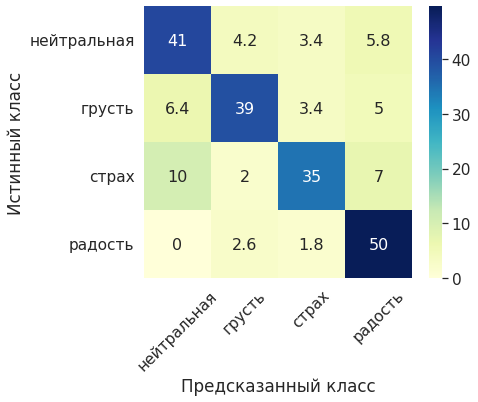

In [45]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(np.mean(conf_mat, axis=0), ['нейтральная', 'грусть', 'страх', 'радость'], 
                     ['нейтральная', 'грусть', 'страх', 'радость'])

plt.figure(figsize=(6,5))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 16}) # font size
ax.set(xlabel='Предсказанный класс', ylabel='Истинный класс')
plt.xticks(rotation=45)
plt.show()

# Time measurement

In [22]:
import time
from tqdm import tqdm

start = time.time()

for j in tqdm(range(10)):
    for i in tqdm(range(216)):
        prediction = model.predict([np.expand_dims(x_test1[i], axis=0), np.expand_dims(x_test2[i], axis=0), 
                                    np.expand_dims(x_test3[i], axis=0), np.expand_dims(x_test4[i], axis=0)], verbose=0)

total = time.time() - start
print(total)
print(total/2160)

 58%|█████▊    | 125/216 [00:06<00:07, 11.59it/s]


 25%|██▍       | 53/216 [00:03<00:16,  9.97it/s]


100%|██████████| 10/10 [01:55<00:00, 11.51s/it]

115.14943027496338
0.053309921423594156
